# Biniary Classification in Sentiment Analysis based on Twitter dataset

## For explanations, please refer to my report. 

## Packages and preliminaries

In [3]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import pickle
import itertools

Using TensorFlow backend.


In [4]:
import sys
import time
from wordcloud import WordCloud
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
cur_dir = sys.path[0]
dataset_path = os.path.join(cur_dir,'training.1600000.processed.noemoticon.csv')
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding ="ISO-8859-1" , names=["target", "ids", "date", "flag", "user", "text"])

Open file: /Users/wsx/Desktop/Python Project_1730013042/training.1600000.processed.noemoticon.csv


In [6]:
len(df)

1600000

In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 429 ms, sys: 36.5 ms, total: 465 ms
Wall time: 465 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

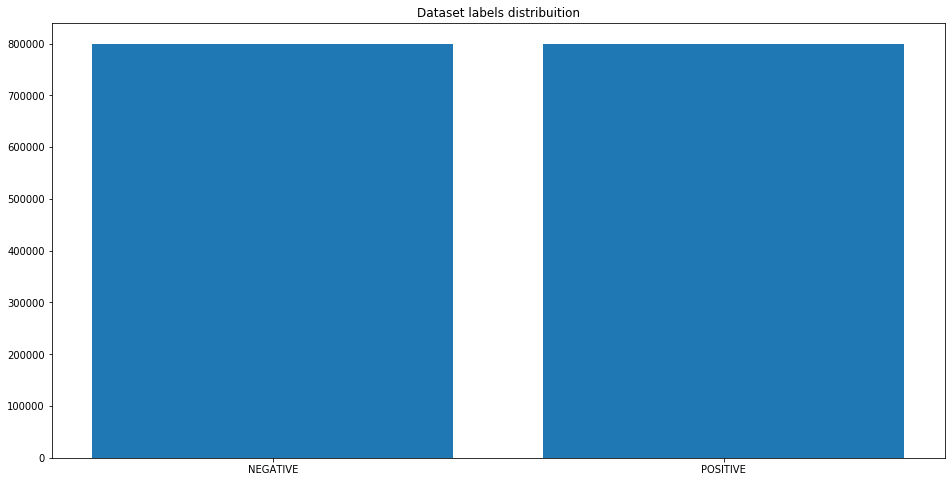

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 38.2 s, sys: 339 ms, total: 38.6 s
Wall time: 38.9 s


In [15]:
df.head(10)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
5,NEGATIVE,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew
6,NEGATIVE,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,NEGATIVE,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rains bit bit lol fine t...
8,NEGATIVE,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
9,NEGATIVE,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera


## Wordcloud

In [16]:
#800000+800000
neg=df.loc[df["target"] == "NEGATIVE"]
pos=df.loc[df["target"] == "POSITIVE"]
test_neg=neg[0:25000]
test_pos=pos[0:25000]
test_df=test_neg.append(test_pos)
test_df.reset_index(inplace=True,drop=True)

In [17]:
a=test_df['text']
b=test_pos['text']
c=test_neg['text']

There are 43095 words in the combination of first 1000 review.


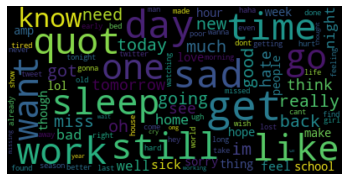

In [18]:
def wordcloudplot(data,color='black'):
# Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords = stop_words, background_color=color).generate(data)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
text = " ".join(review for review in a.iloc[:1000])
print ("There are {} words in the combination of first 1000 review.".format(len(text)))
wordcloudplot(text)

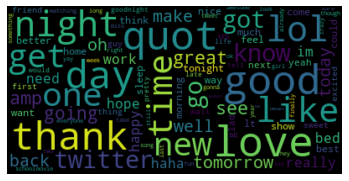

In [19]:
#the first 1000 score-5 reviews in the dataframe, which represent the positive reviews
positive_text =" ".join(review for review in b.iloc[:1000])
#generate wordcloud for positive_text
wordcloudplot(positive_text)

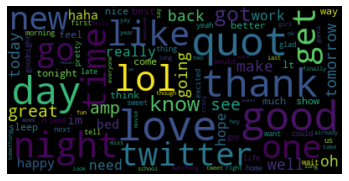

In [20]:
#the first 1000 score-5 reviews in the dataframe, which represent the positive reviews
negative =" ".join(review for review in c.iloc[:1000])
#generate wordcloud for positive_text
wordcloudplot(positive_text)

In [21]:
test_df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


## NaiveBayesClassifier

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [30]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [31]:
f_train, f_test = train_test_split(test_df,test_size = 0.1,random_state=42)
f_train.shape,f_test.shape

((45000, 6), (5000, 6))

In [32]:
f_train_pos = f_train[ f_train['target'] == 'POSITIVE']
f_train_pos = f_train_pos['text']
f_train_neg = f_train[ f_train['target'] == 'NEGATIVE']
f_train_neg = f_train_neg['text']

In [35]:
f_train.head()

,target,ids,date,flag,user,text
40877,POSITIVE,1551243162,Sat Apr 18 08:31:53 PDT 2009,NO_QUERY,deaderic,seems sort working
18057,NEGATIVE,1556485011,Sat Apr 18 23:01:12 PDT 2009,NO_QUERY,newnew_1033,finallly homee loooooong day accompished alot ...
19066,NEGATIVE,1556760508,Sun Apr 19 00:12:59 PDT 2009,NO_QUERY,mrs_tsaur,hmmmm think closed
20525,NEGATIVE,1557089018,Sun Apr 19 01:57:20 PDT 2009,NO_QUERY,itskatherine,sun go
5847,NEGATIVE,1469214728,Tue Apr 07 05:38:10 PDT 2009,NO_QUERY,Letty_f,hi stefan unfortunately go dmb concert brazil ...


In [36]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in f_train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.target))

f_test_pos = f_test[f_test['target'] == 'POSITIVE']
f_test_pos = f_test_pos['text']
f_test_neg = f_test[f_test['target'] == 'NEGATIVE']
f_test_neg = f_test_neg['text']

In [37]:
len(tweets)

45000

In [38]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

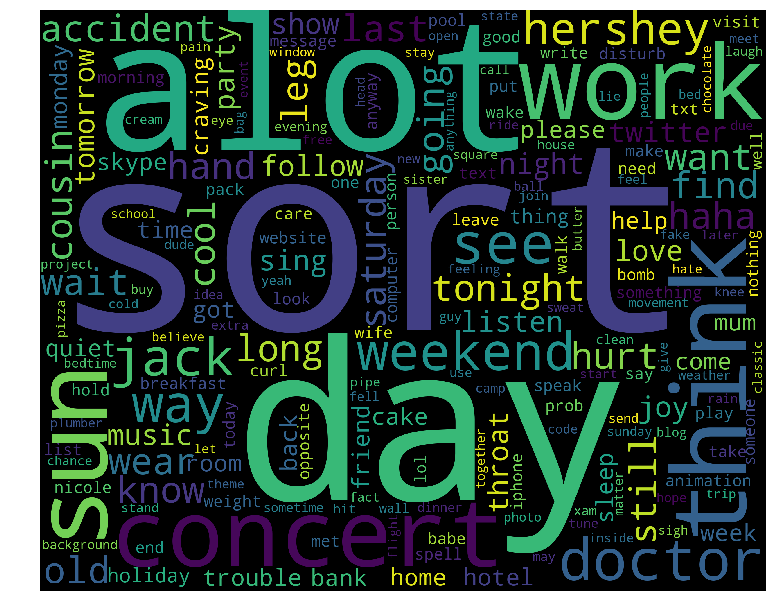

In [39]:
wordcloud_draw(w_features)

In [40]:
#!!!it takes about ten minutes ti run this section!!!
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [44]:
#!!!it takes about ten minutes ti run this section!!!
neg_cnt = 0
pos_cnt = 0
for obj in f_test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'NEGATIVE'): 
        neg_cnt = neg_cnt + 1
for obj in f_test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'POSITIVE'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(f_test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(f_test_pos),pos_cnt))    

[Negative]: 2472/1837 
[Positive]: 2528/1868 


In [45]:
obj='i hate you'

In [46]:
classifier.classify(extract_features(obj.split()))

'NEGATIVE'

In [47]:
print((neg_cnt+pos_cnt)/(len(f_test_neg)+len(f_test_pos)))

0.741


## A series of Machine Learning models

In [22]:
temp=test_df[['text','target']]
temp.head()

,text,target
0,awww bummer shoulda got david carr third day,NEGATIVE
1,upset update facebook texting might cry result...,NEGATIVE
2,dived many times ball managed save 50 rest go ...,NEGATIVE
3,whole body feels itchy like fire,NEGATIVE
4,behaving mad see,NEGATIVE


In [23]:
decode_map = {'NEGATIVE': 0, "POSITIVE": 1}
def binary_decode(label):
    return decode_map[label]

In [24]:
temp.target = temp.target.apply(lambda x: binary_decode(x))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
temp.head()

,text,target
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save 50 rest go ...,0
3,whole body feels itchy like fire,0
4,behaving mad see,0


In [26]:
#from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(temp.text, 
                                                                temp.target, test_size=.2, random_state=SEED)


In [27]:
len(x_train),len(x_validation)

(40000, 10000)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.70
accuracy score: 75.43%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.68
accuracy score: 73.94%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
 

In [30]:
# pip install plotly

In [31]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)

data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [32]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)

In [33]:
py.iplot(fig)

In [34]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

_fp_ = []
_tp_ = []
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], names):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    _fp_.append(fp)
    _tp_.append(tp)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.70
accuracy score: 75.43%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.68
accuracy score: 73.94%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_pri

In [35]:
data = []
for i in range(0, len(_fp_)):
    trace = go.Scatter(x=_fp_[i], y=_tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)

## RNN model

In [36]:
neg=df.loc[df["target"] == "NEGATIVE"]
pos=df.loc[df["target"] == "POSITIVE"]
test_neg=neg[0:10000]
test_pos=pos[0:10000]
test_df=test_neg.append(test_pos)
test_df.reset_index(inplace=True,drop=True)

In [37]:
test_df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [38]:
#test_df['text'].values

In [39]:
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(test_df[ test_df['target'] == 'POSITIVE'].size)
print(test_df[ test_df['target'] == 'NEGATIVE'].size)

for idx,row in test_df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(test_df['text'].values)
# print( tokenizer.word_counts)
# print( tokenizer.word_index)
# print( tokenizer.word_docs)
# print( tokenizer.index_docs)
X = tokenizer.texts_to_sequences(test_df['text'].values)
X = pad_sequences(X)

60000
60000


In [40]:
X.shape

(20000, 23)

In [41]:
# # import keras.preprocessing.text as T
# # from keras.preprocessing.text import Tokenizer
 
# text1='some thing to eat'
# text2='some thing to drink'
# #text3='some thing to play'
# texts=[text1,text2]
 
# tokenizer = Tokenizer(num_words=None)
# tokenizer.fit_on_texts(texts)
# print( tokenizer.word_counts) #[('some', 2), ('thing', 2), ('to', 2), ('eat', 1), ('drink', 1)]
# print( tokenizer.word_index) #{'some': 1, 'thing': 2,'to': 3 ','eat': 4, drink': 5}
# print( tokenizer.word_docs) #{'some': 2, 'thing': 2, 'to': 2, 'drink': 1,  'eat': 1}
# print( tokenizer.index_docs) #{1: 2, 2: 2, 3: 2, 4: 1, 5: 1}

# print( tokenizer.texts_to_sequences(texts))
# #print( tokenizer.texts_to_matrix(texts)
# # [[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
# #  [ 0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]]

 
# # tokenizer = Tokenizer(num_words=None)
# # tokenizer.fit_on_texts(all_texts)
# # sequences = tokenizer.texts_to_sequences(all_texts)
# # word_index = tokenizer.word_index
# # print('Found %s unique tokens.' % len(word_index))
# # data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# # labels = to_categorical(np.asarray(all_labels))
# # print('Shape of data tensor:', data.shape)
# # print('Shape of label tensor:', labels.shape)


In [43]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 23, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
Y = pd.get_dummies(test_df['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(13400, 23) (13400, 2)
(6600, 23) (6600, 2)


In [45]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/7
 - 10s - loss: 0.6008 - accuracy: 0.6620
Epoch 2/7
 - 9s - loss: 0.5109 - accuracy: 0.7475
Epoch 3/7
 - 9s - loss: 0.4827 - accuracy: 0.7682
Epoch 4/7
 - 9s - loss: 0.4579 - accuracy: 0.7831
Epoch 5/7
 - 9s - loss: 0.4339 - accuracy: 0.7990
Epoch 6/7
 - 10s - loss: 0.4089 - accuracy: 0.8087
Epoch 7/7
 - 10s - loss: 0.3848 - accuracy: 0.8243


In [46]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.65
acc: 0.72


In [47]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 73.71967654986523 %
neg_acc 67.01846965699208 %


In [48]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=23, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

negative
